## 어려웠던것들
1. boundary condition 적용 유무
2. "absolute" magnetization 때문에..
    책에서는 그냥 magnetization이라고해서 너무 햇갈렸음
3. symmetry 사용


In [62]:
import numpy as np
import matplotlib.pyplot as plt

1. Quantity Expectation
$$<Q>(T) = \sum_\mu Q_\mu p_\mu = \frac{1}{Z}Q_\mu \exp(-\beta E_\mu) $$
,where $\mu$ indicate the state of system (ex. each configuration of spin in Ising model) and $\beta$ is the notation of $(kT)^{-1}$.

2. Partition funtion
$$ Z(T) = \sum_\mu exp(-\beta E_\mu)$$

3. Probability function
Experimentally, when the enough time passed, probability function follows
$$p_\mu = \frac{1}{Z} \exp(-\beta E_\mu)$$

4. Hamiltonian
$$H(\mu =\{s_i\}) = -J\sum_{i,j} s_i s_{j+1}-B\sum_i s_i$$

where s_{n+1} = s_1. 


Note that usaually use kT as T with energy unit

![nn](img/Barkema_fig1.1.jpg)

In [204]:
global path
path = "./1_Exact_Ising_Calculator_result/"

class Ising:
    def make_all(self,L):
        res = Ising(L)
        res.generator_s(0)
        res.calc()
        res.plot_mag()
        res.plot_spec()
        return res
        

    def __init__(self,L,intv = 25,J = 1,B = 0):
        self.L = L
        self.N = L*L
        self.intv = intv
        self.T = [(5/self.intv)*(k+1) for k in range(self.intv)]
        self.J = J
        self.B = B
        self.cnt = 0
        self.ZU = np.zeros(intv,dtype=np.double)
        self.Z = np.zeros(intv,dtype=np.double)
        self.E2 = np.zeros(intv,dtype=np.double)
        self.E = np.zeros(intv,dtype=np.double)
        self.sc = np.ones(self.N,dtype=np.int0)

    def sweep(self,func): # periodic
        self.cnt += 1
        res = 0
        # print(self.sc)
        for i in range(self.N):
            sum = func(i)

            res += self.J*sum*self.sc[i]

        sigma = np.sum(self.sc)
        HH = -res -self.B*sigma
        # print(sigma,HH)
        for k in range(self.intv):
            T = (5/self.intv)*(k+1)
            ex = np.exp(-HH/T)
            self.ZU[k] += np.absolute(sigma)*ex
            self.Z[k] += ex
            self.E[k] += HH*ex
            self.E2[k] += HH*HH*ex
    
    def pbc(self, i): #periodic boundary condition
        sum = 0

        nn = i + 1
        if(nn % self.L == 0): nn -= self.L
        sum += self.sc[nn]

        nn = i + self.L
        if(nn >= self.N): nn -= self.N
        sum += self.sc[nn]
        return sum
    
    def helical(self,i):
        sum = 0

        nn = i + 1
        if(nn == self.N): nn = 0
        sum += self.sc[nn]

        nn = i + self.L
        if(nn >= self.N): nn -= self.N
        sum += self.sc[nn]
        return sum

    def free_edge(self,i): #free edge
        sum = 0

        nn = i + 1
        if(nn % self.L != 0):
            sum += self.sc[nn]

        nn = i - 1
        if((nn+1) % self.L != 0):
            sum += self.sc[nn]

        nn = i + self.L
        if(nn < self.N):
            sum += self.sc[nn]

        nn = i - self.L
        if(nn >= 0):
            sum += self.sc[nn]

        return sum

    def generator(self,i=0): # not using symmetry
        func = self.sweep
        boundary = self.free_edge
        if(i == self.N): return
        if(i == 0): func(boundary)
        self.sc[i] *= -1
        func(boundary)
        self.generator(i+1)
        self.sc[i] *= -1
        self.generator(i+1)
    
    def generator_s(self,i=1): # using symmetry
        func = self.sweep
        boundary = self.helical
        if(i == self.N): return
        if(i == 1): func(boundary)
        self.sc[i] *= -1
        func(boundary)
        self.generator_s(i+1)
        self.sc[i] *= -1
        self.generator_s(i+1)
    
    def calc(self):
        self.mag = self.magnetization()
        self.spec = self.specific_heat()
        

    def magnetization(self): # not per spin
        res = np.zeros(self.intv)
        for i in range(self.intv):
            res[i] = (1/self.N)*self.ZU[i]/self.Z[i]
        return res
    
    def specific_heat(self):
        res = np.zeros(self.intv)
        for i in range(self.intv):
            # Have to multply boltzman constant k here (or k = 1)
            res[i] = (1/self.N)*(1/self.T[i])**2*(self.E2[i]/self.Z[i] - (self.E[i]/self.Z[i])**2)
        return res

    def plot_mag(self,fname,relative = False):
        plt.cla()
        y = self.mag
        if(relative):
            y = self.mag/max(self.mag)

        plt.style.use('seaborn-whitegrid')
        plt.ylim(0,1.1)
        plt.xlim(0,5)
        plt.plot(self.T,y)

        plt.ylabel('Abosolute magnetization per spin m')
        plt.xlabel('Temperature T')
        plt.savefig(path + fname + "_mag.png")
        plt.show()
    
    def plot_spec(self,fname,relative = False):
        plt.cla()
        y = self.spec
        if(relative):
            y = self.spec/max(self.spec)


        plt.style.use('seaborn-whitegrid')
        plt.ylim(0,2)
        plt.xlim(0,5)
        plt.plot(self.T,y)

        plt.ylabel('Specific heat per spin m')
        plt.xlabel('Temperature T')
        plt.savefig(path + fname + "_spec.png")
        plt.show()
    
    def save(self,fname):
        np.savetxt(path + fname + "_mag", self.mag)
        np.savetxt(path + fname + "_spec", self.spec)

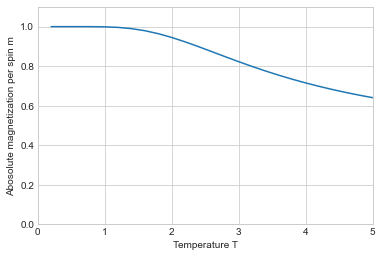

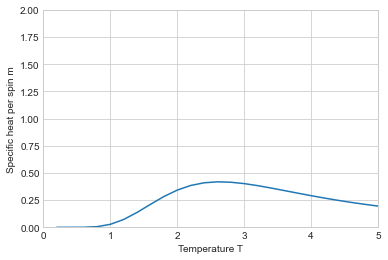

In [205]:
L22 = Ising(2)
L22.generator_s(1)
L22.calc()
L22.plot_mag("L22")
L22.plot_spec("L22")
# L22.save("L22_40intv")

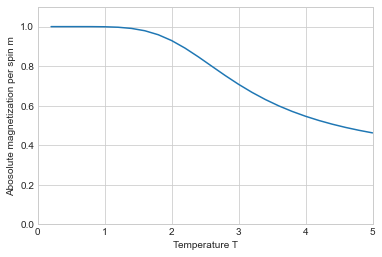

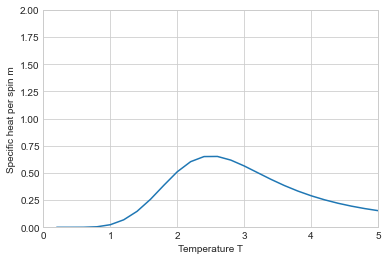

In [206]:
L33 = Ising(3)
L33.generator_s(1)
L33.calc()
L33.plot_mag("L33")
L33.plot_spec("L33")
# L33.save("L33_40intv")

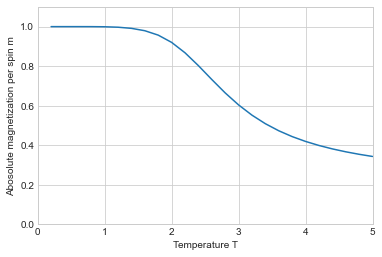

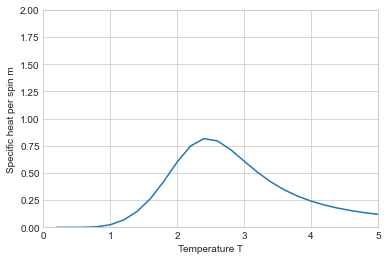

In [203]:
L44 = Ising(4)
L44.generator_s(1)
L44.calc()
L44.plot_mag("L44")
L44.plot_spec("L44")
L44.save("L44_40intv")

In [197]:
L55 = Ising(5,25)
L55.generator_s(1)
L55.calc()
L55.plot_mag("L55")
L55.plot_spec("L55")
L55.save("L55_25intv")

KeyboardInterrupt: 